## Music generation with LSTM in Keras
* Music generation with LSTM in Keras, https://github.com/unmonoqueteclea/DeepLearning-Notebooks/tree/master/LSTM-Music-Generation

* https://unmonoqueteclea.github.io/rnn/lstm/lstm/

* https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

* http://www.piano-midi.de/

In [1]:
!pwd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(0) # gpu idx

/home/hyejoo/work/repos/Capstone19/02_music


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import glob
import pickle
import numpy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6) # Make the figures a bit bigger
    
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
home_music = 'midi_files/'

In [5]:
outDir = 'out'
if not os.path.exists(outDir):
    os.makedirs(outDir)

### Go 

In [10]:
#folder_name = 'chopin'
#folder_name = 'brahms1'
#folder_name = 'childsong'
folder_name = 'chopin1'
#folder_name = 'mozart'
#folder_name = 'game_1'
#folder_name = 'zazz_carol'
#folder_name = 'disney'
#folder_name = 'bit_music'
#folder_name = 'National_Anthems'

to_Train = True
nb_epoch = 100 
sequence_length = 20
sqln = 'sq'+str(sequence_length)

In [11]:
pickle_name = 'notes_'+folder_name+'_'+sqln+'.pickle'
to_load_from_pickle = False #False 

In [12]:
if to_load_from_pickle:
    
    notes = pickle.load( open(pickle_name, "rb" ) )
    
else:    
    notes = []
    for i,file in enumerate(glob.glob(home_music+folder_name+"/*.mid")):
        #print(i, file)
        midi = converter.parse(file)
        print('\r', 'Parsing file ', i, " ",file, end='')
        notes_to_parse = None
        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 

        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            print('------ FLAT Structure --------')

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                str1 = str(element.pitch)
                notes.append(str1)
                #print('pitch --->', str1)
            elif isinstance(element, chord.Chord):
                str1 = '.'.join(str(n) for n in element.normalOrder)
                #print(str1, '<-------', element.normalOrder)
                notes.append(str1)
    
    with open(pickle_name, 'wb') as filepath:
        pickle.dump(notes, filepath)

 Parsing file  1   midi_files/chopin1/chp_op18_format0.mid

In [13]:
len(notes)

6300

In [14]:
# Count different possible outputs
n_vocab = (len(set(notes)))
n_vocab

204

### data processing

In [15]:
#sequence_length = 50 #100
# get all pitch names
pitchnames = sorted(set(item for item in notes))

In [16]:
pitchnames

['0',
 '0.1.5.8',
 '0.3',
 '0.3.4.6.8',
 '0.3.5',
 '0.3.5.6.8',
 '0.3.6',
 '0.3.6.8',
 '0.3.6.9',
 '0.4',
 '0.5',
 '0.6',
 '1',
 '1.3',
 '1.3.7',
 '1.4',
 '1.4.6.9',
 '1.4.7.10',
 '1.5',
 '1.5.8',
 '1.5.9',
 '1.6',
 '1.7',
 '10',
 '10.0.3.5.6',
 '10.0.3.6',
 '10.0.4',
 '10.0.4.5',
 '10.1',
 '10.1.3',
 '10.1.5',
 '10.2',
 '10.2.5',
 '10.3',
 '11',
 '11.1',
 '11.2',
 '11.2.5',
 '11.2.6',
 '11.3',
 '11.4',
 '2',
 '2.3',
 '2.3.8',
 '2.4.8',
 '2.5',
 '2.5.8',
 '2.5.8.10',
 '2.5.8.11',
 '2.6',
 '2.6.10',
 '2.7',
 '2.8',
 '3',
 '3.5',
 '3.5.8.11',
 '3.5.9',
 '3.6',
 '3.6.10',
 '3.6.8',
 '3.7',
 '3.7.10',
 '3.8',
 '3.9',
 '4',
 '4.10',
 '4.5',
 '4.5.7.8',
 '4.6',
 '4.7',
 '4.7.10',
 '4.7.10.0',
 '4.7.10.0.1',
 '4.7.9',
 '4.8',
 '4.8.11',
 '4.9',
 '5',
 '5.10',
 '5.11',
 '5.6.8.0',
 '5.7',
 '5.7.11',
 '5.8',
 '5.8.0',
 '5.8.10',
 '5.8.10.11',
 '5.8.11',
 '5.8.11.1',
 '5.9',
 '5.9.0',
 '6',
 '6.10',
 '6.10.0',
 '6.10.1',
 '6.11',
 '6.7.0',
 '6.8',
 '6.8.0',
 '6.8.11',
 '6.8.11.2',
 '6.9',
 '6.9.

In [17]:
sequence_length

20

In [18]:
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [19]:
pickle_name1 = 'note_to_int_'+folder_name+'_'+sqln+'.pickle'
with open(pickle_name1, 'wb') as filepath:
    pickle.dump(note_to_int, filepath)

In [20]:
#note_to_int

In [21]:
len(notes)- sequence_length

6280

In [22]:
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length] # Size sequence_length
    
    sequence_out = notes[i + sequence_length]  # Size 1
    
    
    
    # Map pitches of sequence_in to integers
    in1 = [note_to_int[char] for char in sequence_in]
    network_input.append(in1)
    
    # Map integer of sequence_out to an integer
    out1 = note_to_int[sequence_out]
    network_output.append(out1)
    
    #print('{} ~~ {} --> {}\t{}-->{}'.format(i,i + sequence_length-1, i + sequence_length, in1, out1))

In [23]:
n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
#one-hot encoding



network_output = np_utils.to_categorical(network_output)

In [24]:
n_patterns

6280

In [25]:
network_input[6279]

array([[0.69117647],
       [0.71568627],
       [0.85294118],
       [0.29411765],
       [0.99509804],
       [0.97058824],
       [0.69117647],
       [0.71568627],
       [0.85294118],
       [0.52941176],
       [0.99509804],
       [0.97058824],
       [0.69117647],
       [0.71568627],
       [0.29411765],
       [0.29411765],
       [0.29901961],
       [0.29901961],
       [0.29901961],
       [0.29901961]])

In [26]:
network_input.shape

(6280, 20, 1)

In [27]:
network_output.shape

(6280, 204)

In [28]:
network_output[5]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### Creating model

In [29]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

In [30]:
n_vocab

204

In [31]:
model = create_network(network_input,n_vocab)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 512)           1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

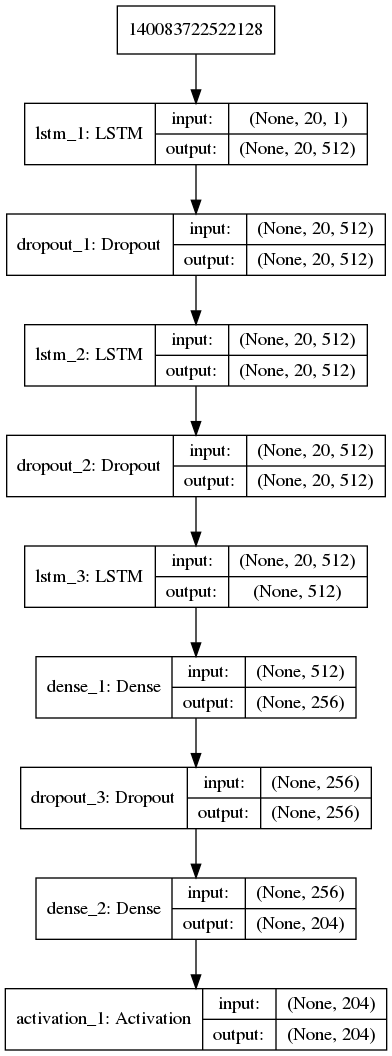

In [32]:
model_name = 'lstm1'
from keras.utils import plot_model
plot_model(model, to_file='{}/model_{}.png'.format(outDir, model_name), show_shapes=True)
from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, model_name))

In [33]:
# In case we want to use previously trained weights
#weights = ""
#if(len(weights)>0): model.load_weights(weights)

In [34]:
#filepath = "/content/drive/My Drive/{epoch:02d}-{loss:.4f}.h5"
fnmodel = '{}/model_{}_{}.h5'.format(outDir, folder_name, nb_epoch)
filepath = outDir+"/"+folder_name+"_{epoch:02d}-{loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=1,
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint]

In [35]:
%%time
if to_Train:
    hist = model.fit(network_input, network_output, epochs=nb_epoch, batch_size=64, 
              callbacks=callbacks_list)
    model.save(fnmodel)
    print('done...saved a model !..{}'.format(fnmodel))
else:
    #model = load_model(fnmodel)
    print('done...loaded a model !..{}'.format(fnmodel))

Epoch 1/100
6280/6280 [==============================] - 6s 1ms/step - loss: 4.7941

Epoch 00001: loss improved from inf to 4.79408, saving model to out/chopin1_01-4.7941.h5
Epoch 2/100
6280/6280 [==============================] - 5s 726us/step - loss: 4.5058

Epoch 00002: loss improved from 4.79408 to 4.50584, saving model to out/chopin1_02-4.5058.h5
Epoch 3/100
6280/6280 [==============================] - 5s 726us/step - loss: 4.4262

Epoch 00003: loss improved from 4.50584 to 4.42622, saving model to out/chopin1_03-4.4262.h5
Epoch 4/100
6280/6280 [==============================] - 5s 726us/step - loss: 4.3830

Epoch 00004: loss improved from 4.42622 to 4.38301, saving model to out/chopin1_04-4.3830.h5
Epoch 5/100
6280/6280 [==============================] - 5s 725us/step - loss: 4.3283

Epoch 00005: loss improved from 4.38301 to 4.32828, saving model to out/chopin1_05-4.3283.h5
Epoch 6/100
6280/6280 [==============================] - 5s 728us/step - loss: 4.2682

Epoch 00006: loss i

6280/6280 [==============================] - 5s 725us/step - loss: 0.1700

Epoch 00048: loss improved from 0.18135 to 0.16997, saving model to out/chopin1_48-0.1700.h5
Epoch 49/100
6280/6280 [==============================] - 5s 724us/step - loss: 0.1708

Epoch 00049: loss did not improve from 0.16997
Epoch 50/100
6280/6280 [==============================] - 5s 722us/step - loss: 0.1609

Epoch 00050: loss improved from 0.16997 to 0.16085, saving model to out/chopin1_50-0.1609.h5
Epoch 51/100
6280/6280 [==============================] - 5s 728us/step - loss: 0.1739

Epoch 00051: loss did not improve from 0.16085
Epoch 52/100
6280/6280 [==============================] - 5s 726us/step - loss: 0.1513

Epoch 00052: loss improved from 0.16085 to 0.15127, saving model to out/chopin1_52-0.1513.h5
Epoch 53/100
6280/6280 [==============================] - 5s 726us/step - loss: 0.1504

Epoch 00053: loss improved from 0.15127 to 0.15043, saving model to out/chopin1_53-0.1504.h5
Epoch 54/100
6280/6

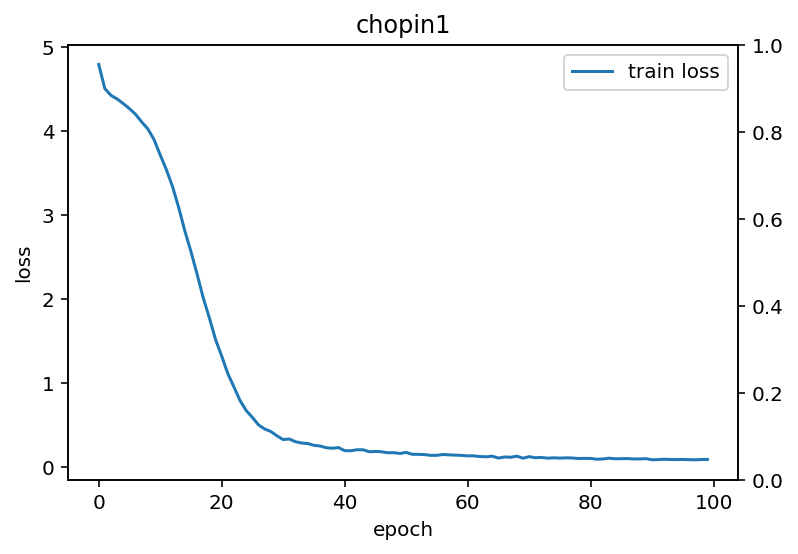

In [36]:
if to_Train:
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'],  label='train loss')
    #loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')
    loss_ax.set_title(folder_name)
    #acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    #acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    #acc_ax.set_ylabel('accuracy')
    #acc_ax.legend(loc='upper center')
    
    fig.savefig('out/{}{}_loss.png'.format(folder_name,sequence_length), dpi=fig.dpi)
    fig.savefig('out/{}{}_loss.svg'.format(folder_name,sequence_length))